In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# параметры распределений
mu0 = [-1.0, -2.0]
cov0 = [[1.0, 0.0], [0.0, 1.0]]

mu1 = [3.0, 3.0]
cov1 = [[1.5, 1.0], [1.0, 1.5]]

In [0]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [0]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0), torch.tensor(cov0))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1), torch.tensor(cov1))

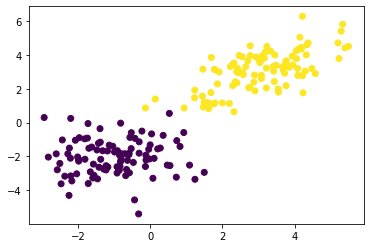

In [5]:
X_s, y_s = sample(d0, d1,100)
plt.scatter(X_s[:,0], X_s[:,1], c=y_s)

In [6]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([0.2270, 0.1383]), tensor(-0.5938)]


In [7]:
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.393620
Ошибка после 1 итераций: 0.189269
Ошибка после 2 итераций: 0.135851
Ошибка после 3 итераций: 0.110313
Ошибка после 4 итераций: 0.095273
Ошибка после 5 итераций: 0.084799
Ошибка после 6 итераций: 0.076305
Ошибка после 7 итераций: 0.071196
Ошибка после 8 итераций: 0.065821
Ошибка после 9 итераций: 0.062839
Ошибка после 10 итераций: 0.059491
Ошибка после 11 итераций: 0.056294
Ошибка после 12 итераций: 0.054603
Ошибка после 13 итераций: 0.051662
Ошибка после 14 итераций: 0.050860
Ошибка после 15 итераций: 0.048280
Ошибка после 16 итераций: 0.047579
Ошибка после 17 итераций: 0.046227
Ошибка после 18 итераций: 0.044743
Ошибка после 19 итераций: 0.044139


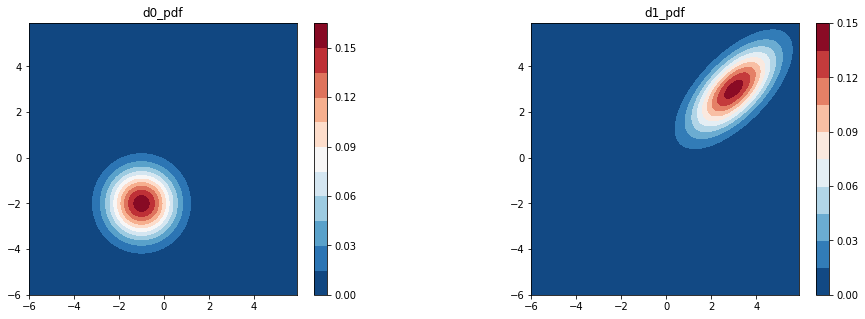

In [8]:
x, y = np.mgrid[-6:6:.1, -6:6:.1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x 
pos[:, :, 1] = y
d0_pdf = stats.multivariate_normal.pdf(pos, mu0, cov0)
d1_pdf = stats.multivariate_normal.pdf(pos, mu1, cov1)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
cntr1 = ax1.contourf(x, y, d0_pdf, levels=10, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax1)
ax1.set_title('d0_pdf')
cntr2 = ax2.contourf(x, y, d1_pdf, levels=10, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax2)
ax2.set_title('d1_pdf')
plt.subplots_adjust(wspace=0.5)

In [9]:
for par in layer.parameters():
  print(par)

Parameter containing:
tensor([[0.9342, 1.1894]], requires_grad=True)
Parameter containing:
tensor([-0.6703], requires_grad=True)


In [0]:
ratio = d1_pdf / (d1_pdf + d0_pdf)

In [0]:
x_tensor = torch.tensor(pos.reshape(-1, 2), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()
dist = dist.reshape(-1, 120)

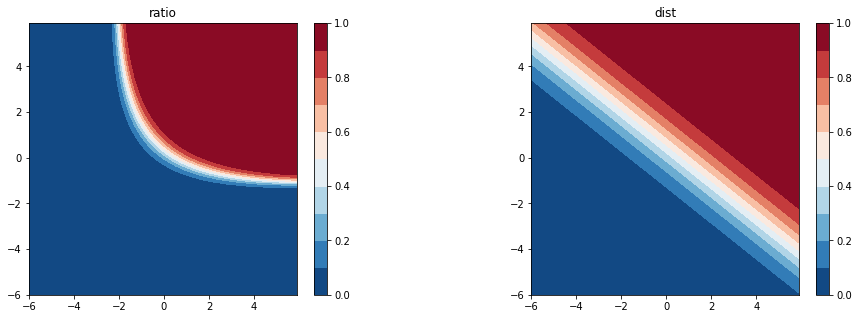

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
cntr1 = ax1.contourf(x, y, ratio, levels=10, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax1)
ax1.set_title('ratio')
cntr2 = ax2.contourf(x, y, dist, levels=10, cmap="RdBu_r")
fig.colorbar(cntr2, ax=ax2)
ax2.set_title('dist')
plt.subplots_adjust(wspace=0.5)